In [1]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip

     \ 348kB 1.2MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47867 sha256=6a376f5c12ad6e8edf122231443e7b70097c19d5510d2be368a0bea9dae15e11
  Stored in directory: /tmp/pip-ephem-wheel-cache-qmki9cb7/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
BETA1 = 0.5
NUM_EPOCHS = 100
NUM_CLASSES = 10
BATCH_SIZE = 100
NOISE_SIZE = 100 

SMOOTHNESS = 0.1

In [6]:
# load data
dataset_train = datasets.CIFAR10(root='./data', train=True, download=True, transform = transforms.ToTensor())
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = True, num_workers= 8)

dataset_test = datasets.CIFAR10(root='./data', train=False, download=True, transform = transforms.ToTensor())
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = BATCH_SIZE, shuffle = True, num_workers= 8)

Files already downloaded and verified
Files already downloaded and verified


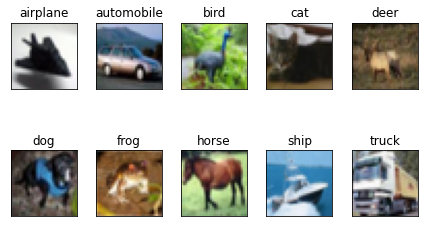

In [7]:
# work with data
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

for i in range(10):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    for j in range(50000):
        if dataset_train[j][1] == i:
            idx = j
            break
    img = F.to_pil_image(dataset_train[idx][0])
    ax.set_title(class_names[i])
    #print(img)
    plt.imshow(img)
plt.tight_layout()

In [8]:
# use average pooling for downscaling
def get_downscaled(image):
    out1 = image
    out2 = torch.nn.functional.interpolate(image, size = (16,16))
    out3 = torch.nn.functional.interpolate(image, size = (8,8))
    out4 = torch.nn.functional.interpolate(image, size = (4,4))
    return out1, out2, out3, out4

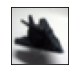

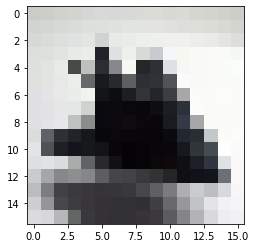

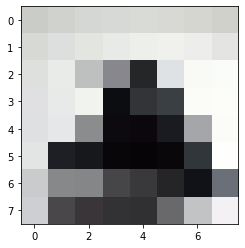

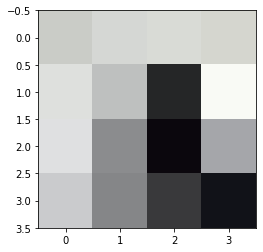

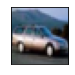

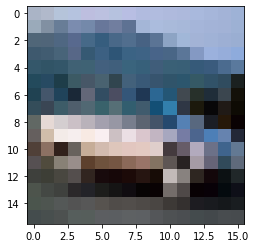

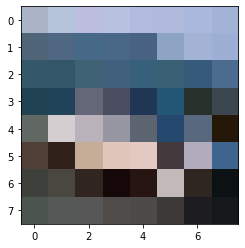

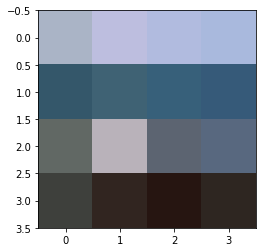

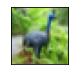

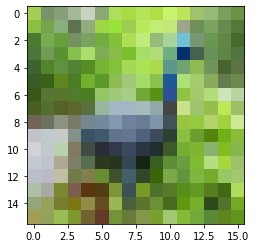

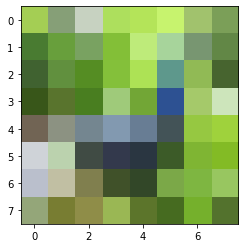

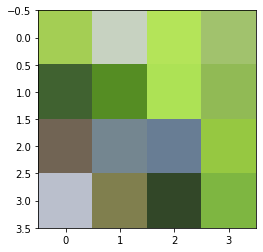

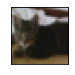

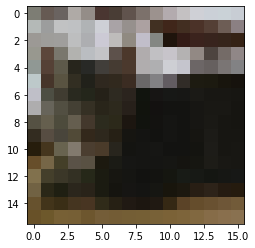

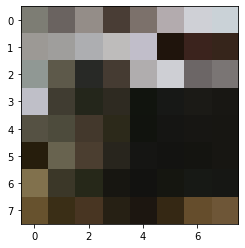

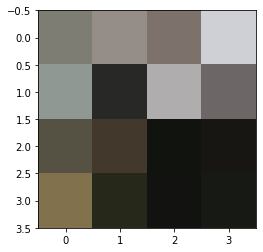

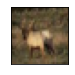

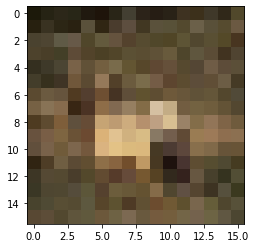

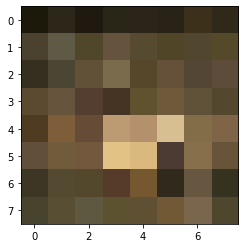

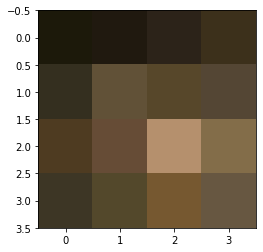

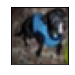

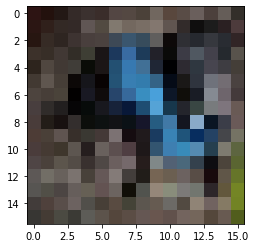

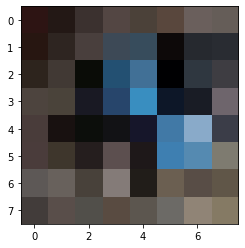

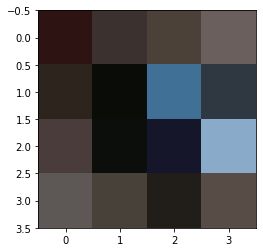

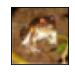

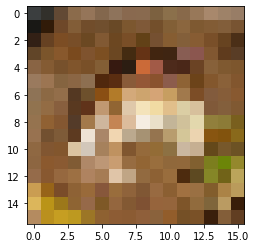

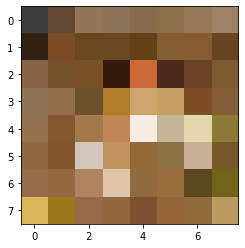

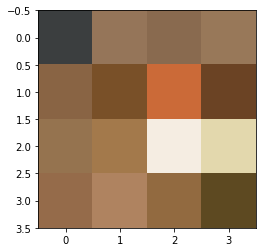

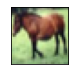

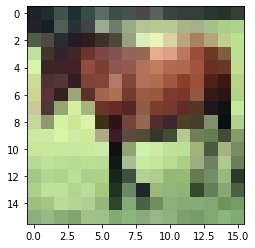

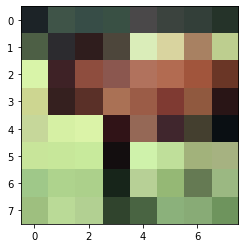

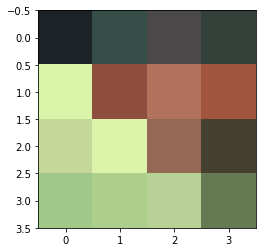

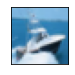

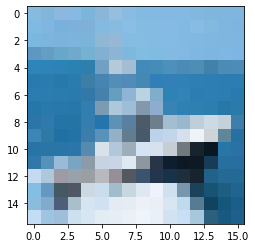

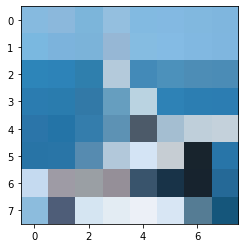

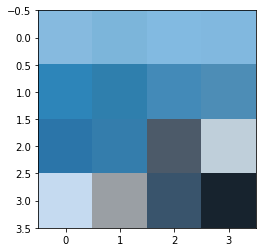

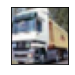

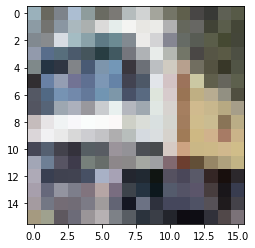

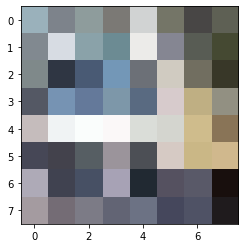

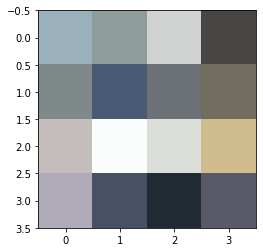

<Figure size 432x288 with 0 Axes>

In [9]:
# work with data
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

for i in range(10):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    for j in range(50000):
        if dataset_train[j][1] == i:
            idx = j
            break
    for ii in get_downscaled(dataset_train[idx][0].unsqueeze(0)):
        
        img = F.to_pil_image(ii[0])
        #ax.set_title(class_names[i])
        #print(img)
        plt.imshow(img)
        plt.show()
plt.tight_layout()

In [10]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.dense = torch.nn.Sequential(
            torch.nn.Linear(in_features = NOISE_SIZE + 10 , out_features= 512 *2*2),
            torch.nn.BatchNorm1d(2048, momentum =  0.9),
            torch.nn.LeakyReLU(0.1)
        )
        
        self.ReLU = torch.nn.ReLU()
        self.conv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels= 512 , out_channels= 256, kernel_size=5, stride=2, padding=2, output_padding= 1),
            torch.nn.BatchNorm2d(256,momentum =  0.9),
            torch.nn.LeakyReLU(0.1)
        )
        
        self.out1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 256, out_channels = 3, kernel_size = 1, stride = 1)
        )
        
        self.conv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels= 256, out_channels= 128, kernel_size=5, stride=2, padding=2, output_padding= 1),
            torch.nn.BatchNorm2d(128, momentum =  0.9),
            torch.nn.LeakyReLU(0.1)
        )
        
        self.out2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 128, out_channels = 3, kernel_size = 1, stride = 1)
        )
        
        self.conv3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels= 128, out_channels= 64, kernel_size=5, stride=2, padding=2, output_padding= 1),
            torch.nn.BatchNorm2d(64, momentum =  0.9),
            torch.nn.LeakyReLU(0.1)
        )
        
        self.out3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size = 1, stride = 1)
        )
        
        self.conv4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels= 64, out_channels= 3, kernel_size=5, stride=2, padding=2, output_padding= 1),
        )

    def forward(self, noise, labels):
        """
        noise has shape (BATCHSIZE, 1)
        labels has shape (BATCHSIZE,)
        """
        
        labels = torch.nn.functional.one_hot(labels, num_classes = 10) #shape (BATCH_SIZE, 10)
        temp = torch.cat((noise, labels.float()), 1) #shape (BATCH_SIZE, NOISE_SIZE)
        temp = self.dense(temp) #shape (BATCH_SIZE, 2048)
        #temp = self.ReLU(temp)
        
        temp = torch.reshape(temp, (-1, 512,2,2))  # shape (BATCH_SIZE, 512,2,2)
        temp = self.conv1(temp) # shape (BATCH_SIZE, 256, 4, 4)
        out1 = self.out1(temp)
        temp = self.conv2(temp) # shape (BATCH_SIZE, 128, 8, 8)
        out2 = self.out2(temp)
        temp = self.conv3(temp) # shape (BATCH_SIZE, 64, 16, 16)
        out3 = self.out3(temp)
        temp = self.conv4(temp) # shape (BATCH_SIZE, 3, 32, 32)
        
        return torch.tanh(out1), torch.tanh(out2), torch.tanh(out3), torch.tanh(temp) # kleinstes zuerst
        
    
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 3, out_channels= 64, kernel_size=5, stride= 2, padding=2),
            torch.nn.BatchNorm2d(64,momentum= 0.9),
            torch.nn.LeakyReLU(negative_slope=0.1)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 67, out_channels= 128, kernel_size=5, stride=2, padding=2),
            torch.nn.BatchNorm2d(128,momentum= 0.9),
            torch.nn.LeakyReLU(negative_slope=0.1)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 131, out_channels= 256, kernel_size=5, stride=2, padding=2),
            torch.nn.BatchNorm2d(256, momentum= 0.9),
            torch.nn.LeakyReLU(negative_slope=0.1)
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 259, out_channels= 512, kernel_size=5, stride=2, padding=2),
            torch.nn.BatchNorm2d(512,momentum= 0.9),
            torch.nn.LeakyReLU(negative_slope=0.1)
        )
        
        self.flatten = torch.nn.Flatten()
        
        self.fully_connected = torch.nn.Sequential(
            torch.nn.Linear(2058, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1),
            torch.nn.Sigmoid()
        )
        
    def forward(self, image1, image2, image3, image4, labels): #größtes zuerst
        temp = self.conv1(image1) # [100, 64, 16, 16]
        temp = torch.cat([temp, image2],1) # [100, 67, 16, 16]
        
        temp = self.conv2(temp) # [100, 128, 8, 8]
        temp = torch.cat([temp, image3],1) # [100, 131, 8, 8]
        
        temp = self.conv3(temp) # [100, 256, 4, 4]
        temp = torch.cat([temp, image4],1) # [100, 259, 4, 4]

        temp = self.conv4(temp) # [100, 512, 2, 2]
        temp = self.flatten(temp) # [100, 2048]

        # bring label in right form and add as dimention
        temp_labels = torch.nn.functional.one_hot(labels, num_classes = 10)
        temp = torch.cat([temp, temp_labels.float()], 1) # [100, 2058]
        out = self.fully_connected(temp)
        
        return out
        

In [11]:
#opt

real_label = 1
false_label = 0

Gen = Generator()
Disc = Discriminator()

opt_gen = torch.optim.Adam(Gen.parameters(), lr = 0.0002, betas = (BETA1, 0.999))
opt_disc = torch.optim.Adam(Disc.parameters(), lr = 0.0002, betas = (BETA1, 0.999))
loss = torch.nn.BCELoss()

Gen = Gen.cuda()
Disc = Disc.cuda()

/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


epoch: 0


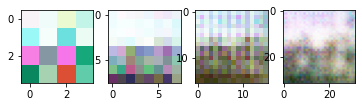

label: airplane
D-Loss is 0.5329487919807434 and G-Loss is 4.824734210968018


In [ ]:
# training
i = 0
for epoch in tqdm(range(NUM_EPOCHS)):
    for image, category in tqdm(data_loader_train):
        i += 1
        image = image.cuda()
        category = category.cuda()

        # train Discriminator--------------------------------------
        opt_disc.zero_grad()
        
        # train with true pictures -----
        
        images = get_downscaled(image)
        output = Disc(*images, category)
        
        label = torch.full(size = (BATCH_SIZE,1), fill_value = real_label * (1- SMOOTHNESS))
        label = label.cuda()
        disc_loss_real = 0
        disc_loss_real = loss(output, label)
        #disc_loss_real.backward()
        
        #train with generated pictures -----
        
        #generate input from Generator
        # noise is taken from N(0,1) distribution
        noise = torch.randn(size = (BATCH_SIZE, NOISE_SIZE))
        noise = noise.cuda()
        gen_categories = torch.randint(low = 0, high = 10, size = (BATCH_SIZE,))
        gen_categories = gen_categories.cuda()
        inputs = Gen(noise, gen_categories)
        inp = [i.detach() for i in inputs][::-1]
        output = Disc(*inp, gen_categories)
        
        label = torch.full(size = (BATCH_SIZE, 1), fill_value = false_label)
        label = label.cuda()
        
        #disc_loss_false.backward()
        
        disc_loss_false = loss(output, label)
        disc_loss = (1/2) * (disc_loss_false + disc_loss_real)
        
        disc_loss.backward()
        opt_disc.step()
        
        # train Generator--------------------------------------
        opt_gen.zero_grad()
        #we don't calculate noise and gen_categories twice, inp stays the same
        # we updated Disc so we calculate it again
        output = Disc(*inputs[::-1], category)
        
        label = torch.full(size = (BATCH_SIZE, 1), fill_value = real_label)
        label = label.cuda()
        # we calculate the difference to the real label
        
        batch_loss = loss(output, label)
        batch_loss.backward()
        opt_gen.step()   
        
    print("epoch: " + str(epoch))
    if epoch %5 == 0:
      for index, ii in enumerate(inp[::-1]):
        ii = ii.cpu()
        Img = F.to_pil_image(ii[0])
        plt.subplot(1,4,index+1)
        plt.imshow(Img)
      plt.show()
      print("label: " + class_names[gen_categories[0].item()])
    print("D-Loss is " + str(disc_loss.item()) + " and G-Loss is " + str(batch_loss.item()))
        

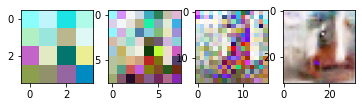

label: deer


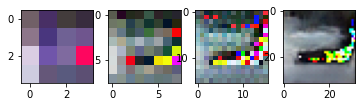

label: horse


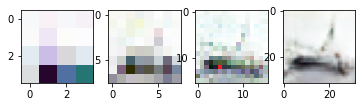

label: deer


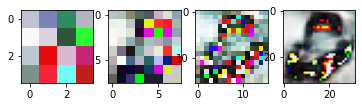

label: truck


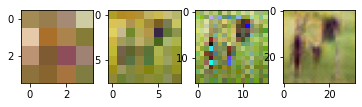

label: horse


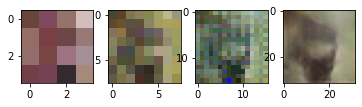

label: truck


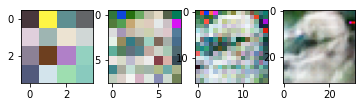

label: frog


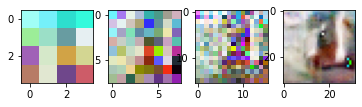

label: automobile


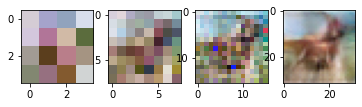

label: ship


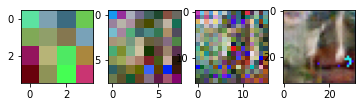

label: airplane


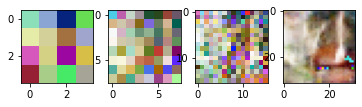

label: frog


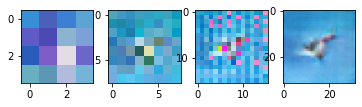

label: horse


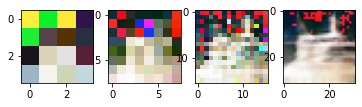

label: airplane


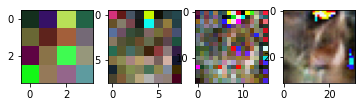

label: deer


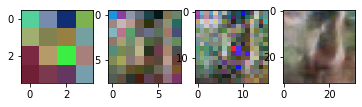

label: dog


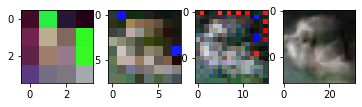

label: cat


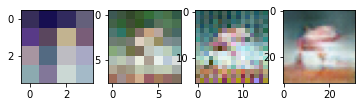

label: frog


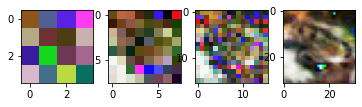

label: dog


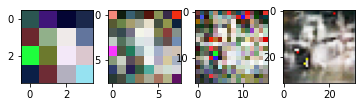

label: frog


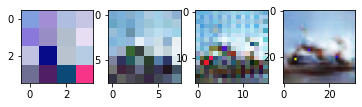

label: frog


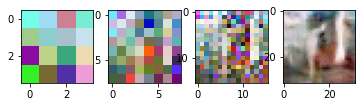

label: frog


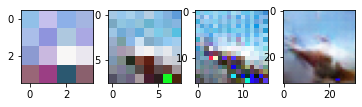

label: bird


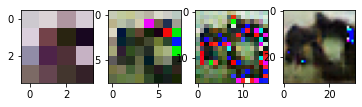

label: truck


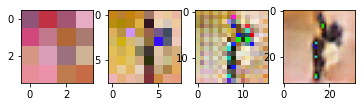

label: cat


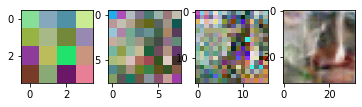

label: automobile


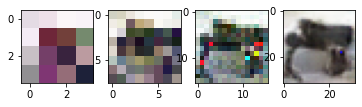

label: truck


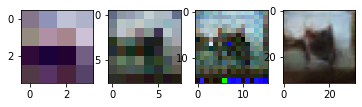

label: airplane


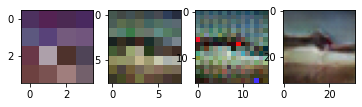

label: frog


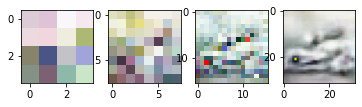

label: horse


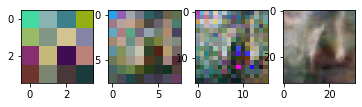

label: deer


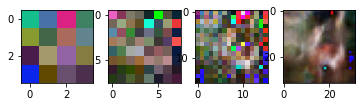

label: ship


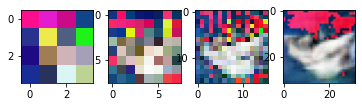

label: bird


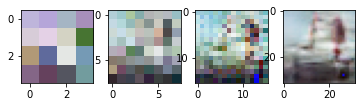

label: frog


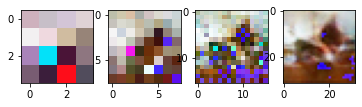

label: bird


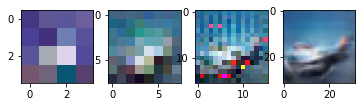

label: automobile


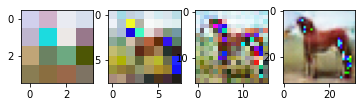

label: dog


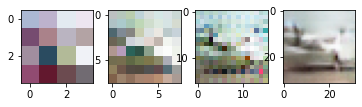

label: cat


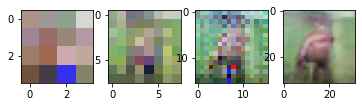

label: deer


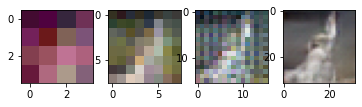

label: ship


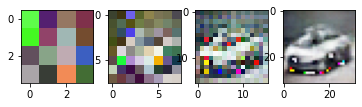

label: ship


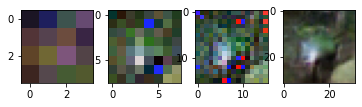

label: dog


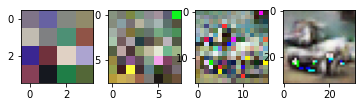

label: deer


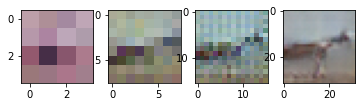

label: bird


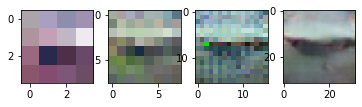

label: deer


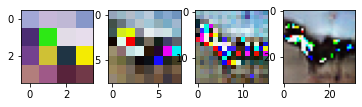

label: dog


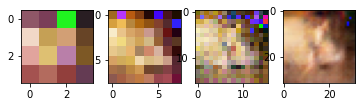

label: dog


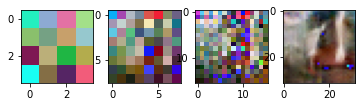

label: frog


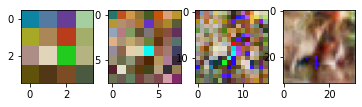

label: automobile


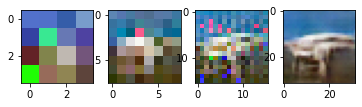

label: ship


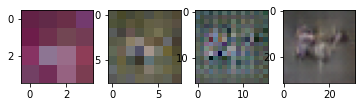

label: truck


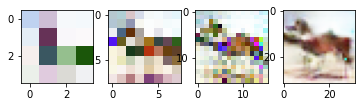

label: frog


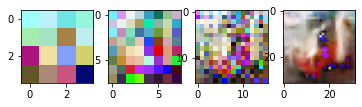

label: frog


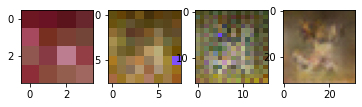

label: airplane


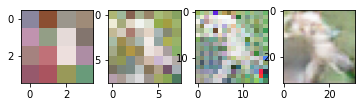

label: horse


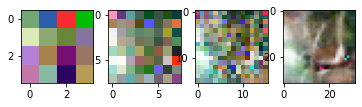

label: dog


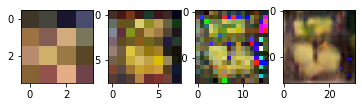

label: truck


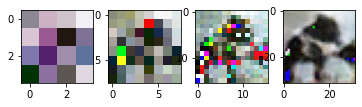

label: cat


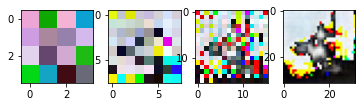

label: airplane


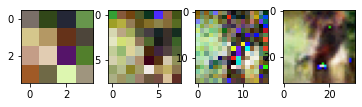

label: bird


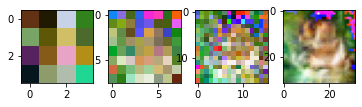

label: deer


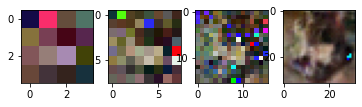

label: airplane


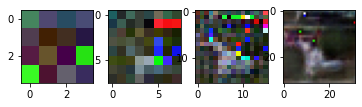

label: bird


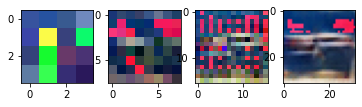

label: dog


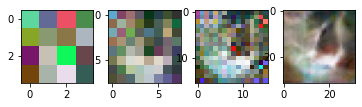

label: horse


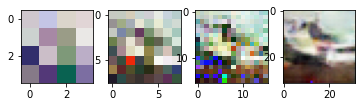

label: airplane


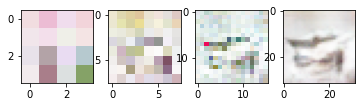

label: ship


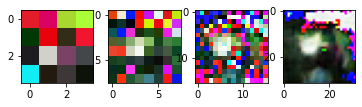

label: cat


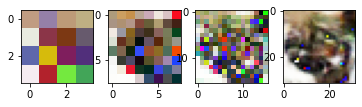

label: automobile


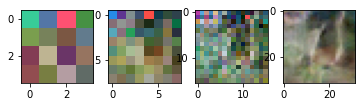

label: ship


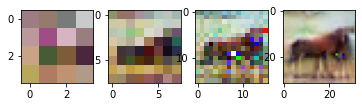

label: ship


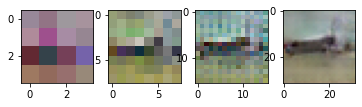

label: bird


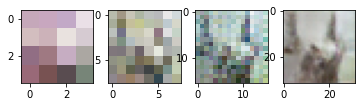

label: dog


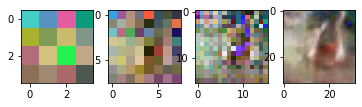

label: deer


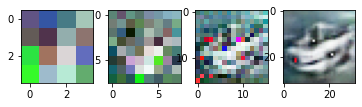

label: deer


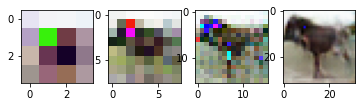

label: airplane


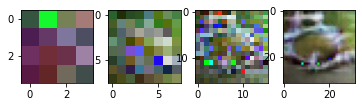

label: horse


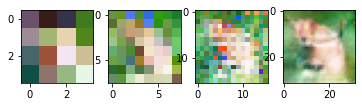

label: automobile


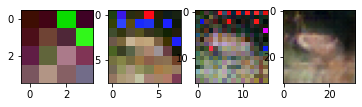

label: frog


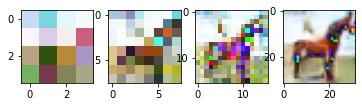

label: frog


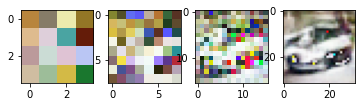

label: automobile


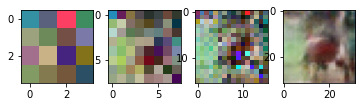

label: horse


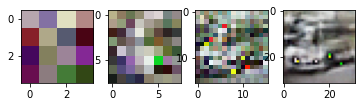

label: bird


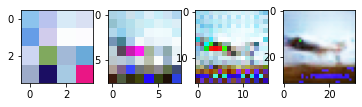

label: deer


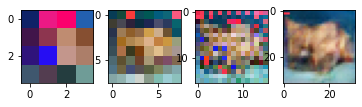

label: automobile


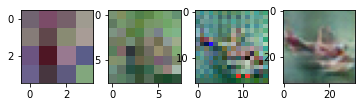

label: truck


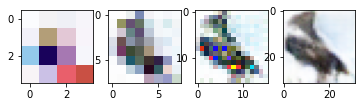

label: automobile


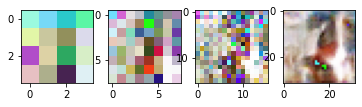

label: ship


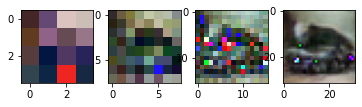

label: dog


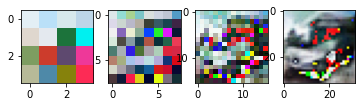

label: truck


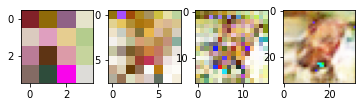

label: airplane


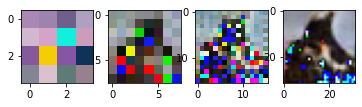

label: dog


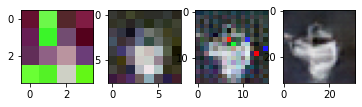

label: bird


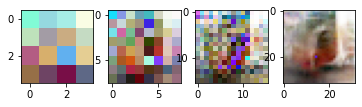

label: airplane


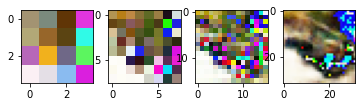

label: deer


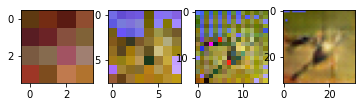

label: ship


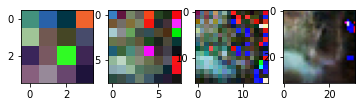

label: ship


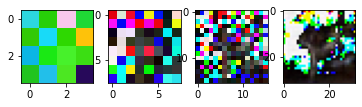

label: bird


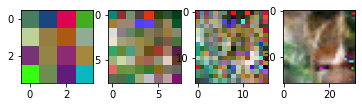

label: horse


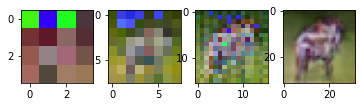

label: deer


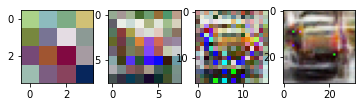

label: dog


In [ ]:
for iii in range(100):
  for index, ii in enumerate(inp[::-1]):
    ii = ii.cpu()
    Img = F.to_pil_image(ii[iii])
    plt.subplot(1,4,index+1)
    plt.imshow(Img)
  plt.show()
  print("label: " + class_names[gen_categories[iii].item()])